In [1]:
import os
import numpy as np
import pandas as pd
import catboost
import scoring
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
import subprocess
import lightgbm as lgb

import datetime

In [2]:
DATA_PATH = "/data/kondratov/data"
SAVED_MODELS_PATH = "/data/kondratov/models"
RANDSEED = None
# Constant if models are not trained
TRAIN = False
# Constant if required to save models
SAVE = True

# Data features
SIMPLE_FEATURE_COLUMNS = ['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
    'avg_cs[2]', 'avg_cs[3]', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]',
    'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]', 'MatchedHit_X[0]',
    'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]',
    'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]',
    'MatchedHit_Y[3]', 'MatchedHit_Z[0]', 'MatchedHit_Z[1]',
    'MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'MatchedHit_T[0]',
    'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]',
    'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
    'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
    'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
    'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
    'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]',
    'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]',
    'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]', 'Lextra_Y[2]',
    'Lextra_Y[3]', 'Mextra_DY2[0]', 'Mextra_DY2[1]', 'Mextra_DY2[2]',
    'Mextra_DY2[3]', 'Mextra_DX2[0]', 'Mextra_DX2[1]', 'Mextra_DX2[2]',
    'Mextra_DX2[3]', 'P', 'PT', ]


In [3]:
class AdaptiveClassifierLoss(object):
    def __init__(self, prob_first_clf, prob_full):
        self.prob_first_clf = prob_first_clf
        self.count = len(prob_first_clf)
        self.prob_full = prob_full
        self.q = np.zeros(self.count)
        self.last_gate = np.zeros(self.count)
        self.last_clf = np.zeros(self.count)
    def loss_clf(self, preds, train_data):
        labels = train_data.get_label() * 2 - 1
        exp_clf = np.exp(-labels * preds)
        exp_sum = 1 + exp_clf
        grad = -(1 - self.q) * labels * exp_clf / exp_sum
        hess = (1 - self.q) * exp_clf / exp_sum / exp_sum
        return grad, hess
    def loss_gate(self, preds, train_data):
        labels = train_data.get_label()
        exp_gate = np.exp(-preds)
        exp_sum = 1 + exp_gate
        grad = (1 - self.q) / exp_sum - self.q * exp_gate / exp_sum
        hess = exp_gate / exp_sum / exp_sum
        return grad, hess
    def set_score_clf(self, score):
        self.last_clf = score
    def set_score_gate(self, score):
        self.last_gate = score
    def update(self, labels, score_second_clf, score_gate):
        self.last_gate = np.zeros(self.count)
        self.last_clf = np.zeros(self.count)
        exp_b = -np.log(self.prob_first_clf) + np.log(1 + np.exp(-score_gate))
        exp_a = -np.log(1 + np.exp(-labels * score_second_clf)) + np.log(1 + np.exp(score_gate))
        min_beta = 0.0001
        max_beta = 100000
        diff = 0.0001
        exp_g = 1. / (1 + np.exp(score_gate))
        exp_s = 1. / (1 + np.exp(labels * score_second_clf))
        exp_first = self.prob_first_clf * exp_g
        exp_second = (1 - exp_g) * exp_s
        while max_beta - min_beta > diff:
            beta = (max_beta + min_beta) / 2
            q_sum = np.sum(exp_first / (exp_first + exp_second * beta)) / self.count
            if q_sum < self.prob_full:
                max_beta = beta
            else:
                min_beta = beta
        self.q = exp_first / (exp_first + exp_second * beta)

In [4]:
class GatedClassifier(object):
    def __init__(self, param_first, param_second, prob_full=0.7,
                 first_clf=None, second_clf=None, gate_clf=None):
        self.param_first = param_first
        self.param_second = param_second
        self.prob_full = prob_full
        self.first_clf = None
        self.second_clf = None
        self.gate_clf = None
        if first_clf is not None:
            self.first_clf = first_clf
        if  second_clf is not None and gate_clf is not None:
            self.second_clf = second_clf
            self.gate_clf = gate_clf
    def train(self, data):
        transformed_data = lgb.Dataset(data.loc[:, SIMPLE_FEATURE_COLUMNS],
                                       data.label,
                                       weight=data.weight,
                                       free_raw_data=False)
        if self.first_clf is None:
            self.first_clf = lgb.train(self.param_first, transformed_data, feature_name=SIMPLE_FEATURE_COLUMNS,
                                       num_boost_round=self.param_first['num_iterations'])
        self.second_clf = lgb.Booster(self.param_second, transformed_data)
        self.gate_clf = lgb.Booster(self.param_second, transformed_data)
        max_iter = 5
        prob_first_clf = self.first_clf.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values)
        loss = AdaptiveClassifierLoss(prob_first_clf, self.prob_full)
        for it in range(max_iter):
            score_second_clf = self.second_clf.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values, raw_score=True)
            score_gate_clf = self.gate_clf.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values, raw_score=True)
            loss.update(data.label.values, score_second_clf, score_gate_clf)
            self.second_clf = lgb.Booster(self.param_second, transformed_data)
            self.gate_clf = lgb.Booster(self.param_second, transformed_data)
            for tree in range(self.param_second['num_iterations']):
                self.second_clf.update(fobj=loss.loss_clf)
                self.gate_clf.update(fobj=loss.loss_gate)
                score_second_clf = self.second_clf.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values, raw_score=True)
                score_gate_clf = self.gate_clf.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values, raw_score=True)
                loss.set_score_clf(score_second_clf)
                loss.set_score_gate(score_gate_clf)
        self.q = loss.q
            
    def predict(self, data):
        gate = self.gate_clf.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values)
        first = self.first_clf.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values, raw_score=True)
        second = self.second_clf.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values, raw_score=True)
        for it in range(len(first)):
            if gate[it] < self.prob_full:
                first[it] = second[it]
        return first
    def predict_timeless(self, data):
        # This method works slow on Python, use C++ version or predict() method instead
        for _, row in data.iterrows():
            gate = self.gate_clf.predict(row.loc[SIMPLE_FEATURE_COLUMNS].values.reshape(1, -1))
            if gate > self.prob_full:
                pred.append(self.first_clf.predict(row.loc[SIMPLE_FEATURE_COLUMNS].values.reshape(1, -1), raw_score=True))
            else:
                pred.append(self.second_clf.predict(row.loc[SIMPLE_FEATURE_COLUMNS].values.reshape(1, -1), raw_score=True))
        return np.array(pred)
            
        

Code was written similar to the example from here: https://github.com/catboost/benchmarks/blob/master/shap_speed/speed_comparison.ipynb

In [5]:
def train_model(data, parameters={}, boosting=None, model=None):
    if boosting == 'Baseline':
        model = catboost.CatBoostClassifier(iterations=550, max_depth=8,
                                            learning_rate=parameters['learning_rate'],
                                            thread_count=16, verbose=False)
        model.fit(data.loc[:, SIMPLE_FEATURE_COLUMNS].values,
                  data.label.values,
                  sample_weight=data.weight.values)
    elif boosting == 'CatBoostClassifier':
        if model is None:
            params = {}
            if "learning_rate" in parameters:
                params["learning_rate"] = parameters["learning_rate"]
            if "max_depth" in parameters:
                params["max_depth"] = parameters["max_depth"]
            else:
                params["max_depth"] = 8
            if "tree_count" in parameters:
                params["iterations"] = parameters["tree_count"]
            else:
                params["iterations"] = 550
            model = catboost.CatBoostClassifier(thread_count=16, verbose=False, **params)
        model.fit(data.loc[:, SIMPLE_FEATURE_COLUMNS].values,
              data.label.values,
              sample_weight=data.weight.values)
    elif boosting == 'CEGB':
        params = {
            'boosting_type': 'cegb',
            'objective': 'binary',
            'metric': 'binary_logloss',
            'num_leaves': 25,
            'max_depth': 8,
            'num_iterations': 1000,
            'learning_rate': 0.3,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0,
        }
        if "learning_rate" in parameters:
            params['learning_rate'] = parameters["learning_rate"]
        trees = 100
        if "tree_count" in parameters:
            trees = parameters["tree_count"]
            params['num_iterations'] = parameters["tree_count"]
        if "num_leaves" in parameters:
            params['num_leaves'] = parameters["num_leaves"]
        if "max_bin" in parameters:
            params['max_bin'] = parameters["max_bin"]
        model = lgb.train(params, data, feature_name=SIMPLE_FEATURE_COLUMNS,
                          num_boost_round=trees)
    elif boosting == 'AdaptiveCassifier':
        params_first = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'binary_logloss',
            'num_leaves': 25,
            'max_depth': 8,
            'num_iterations': 50,
            'learning_rate': 0.3,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0,
        }
        if "learning_rate" in parameters['first']:
            params_first['learning_rate'] = parameters['first']["learning_rate"]
        if "tree_count" in parameters['first']:
            params_first['num_iterations'] = parameters['first']["tree_count"]
        if 'first_clf' in parameters:
            first_clf = parameters['first_clf']
        else:
            first_clf = None
        params_second = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'binary_logloss',
            'num_leaves': 25,
            'max_depth': 5,
            'num_iterations': 10,
            'learning_rate': 0.9,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0,
        }
        if "learning_rate" in parameters['second']:
            params_second['learning_rate'] = parameters['second']["learning_rate"]
        if "tree_count" in parameters['second']:
            params_second['num_iterations'] = parameters['second']["tree_count"]
        model = GatedClassifier(params_first, params_second, prob_full=parameters['threshold'])
        model.train(data)
    else:
        raise RuntimeError("Unknown boosting")
    return model

In [6]:
def evaluate(data, parameters, boosting, model):
    if boosting == 'Baseline':
        testing = subprocess.Popen(['cpp/catboost_eval',
                                    '-model', os.path.join(SAVED_MODELS_PATH, 'baseline.cbm'),
                                    '-output', os.path.join(DATA_PATH, 'tmp/model_pred.csv'),
                                    '-time', os.path.join(DATA_PATH, 'tmp/time.txt'),
                                    '-input', os.path.join(DATA_PATH, 'transformed_test_features.csv')],
                                    stdout=subprocess.PIPE)
        testing.wait()
        file = open(os.path.join(DATA_PATH, 'tmp/time.txt'))
        st = file.readline()
        time = float(st)
        pred = pd.read_csv(os.path.join(DATA_PATH, 'tmp/model_pred.csv'))
        accuracy = scoring.rejection90(data.label.values, pred.prediction.values, data.weight.values)
    elif boosting == 'CatBoostClassifier':
        testing = subprocess.Popen(['cpp/catboost_eval',
                                    '-model', os.path.join(SAVED_MODELS_PATH, create_path(boosting, parameters)),
                                    '-output', os.path.join(DATA_PATH, 'tmp/model_pred.csv'),
                                    '-time', os.path.join(DATA_PATH, 'tmp/time.txt'),
                                    '-input', os.path.join(DATA_PATH, 'transformed_test_features.csv')],
                                    stdout=subprocess.PIPE)
        testing.wait()
        file = open(os.path.join(DATA_PATH, 'tmp/time.txt'))
        st = file.readline()
        time = float(st)
        pred = pd.read_csv(os.path.join(DATA_PATH, 'tmp/model_pred.csv'))
        accuracy = scoring.rejection90(data.label.values, pred.prediction.values, data.weight.values)
    elif boosting == 'CEGB':
        testing = subprocess.Popen(['cpp/cegb_eval',
                                    '-model', os.path.join(SAVED_MODELS_PATH, create_path(boosting, parameters)),
                                    '-output', os.path.join(DATA_PATH, 'tmp/model_pred.csv'),
                                    '-time', os.path.join(DATA_PATH, 'tmp/time.txt'),
                                    '-input', os.path.join(DATA_PATH, 'transformed_test_features.csv'),],
                                    stdout=subprocess.PIPE)
        testing.wait()
        file = open(os.path.join(DATA_PATH, 'tmp/time.txt'))
        st = file.readline()
        time = float(st)
        pred = pd.read_csv(os.path.join(DATA_PATH, 'tmp/model_pred.csv'))
        accuracy = scoring.rejection90(data.label.values, pred.prediction.values, data.weight.values)
    elif boosting == 'AdaptiveCassifier':
        testing = subprocess.Popen(['cpp/gate_eval',
                                    '-first', os.path.join(SAVED_MODELS_PATH, create_path('AdaptFirst', parameters['first'])),
                                    '-second', os.path.join(SAVED_MODELS_PATH, create_path('AdaptSecond', parameters['second'])),
                                    '-gate', os.path.join(SAVED_MODELS_PATH, create_path('AdaptGate', parameters['second'])),
                                    '-threshold', str(parameters['threshold']),
                                    '-output', os.path.join(DATA_PATH, 'tmp/model_pred.csv'),
                                    '-time', os.path.join(DATA_PATH, 'tmp/time.txt'),
                                    '-input', os.path.join(DATA_PATH, 'transformed_test_features.csv'),],
                                    stdout=subprocess.PIPE)
        testing.wait()
        file = open(os.path.join(DATA_PATH, 'tmp/time.txt'))
        st = file.readline()
        time = float(st)
        pred = pd.read_csv(os.path.join(DATA_PATH, 'tmp/model_pred.csv'))
        accuracy = scoring.rejection90(data.label.values, pred.prediction.values, data.weight.values)
    else:
        raise RuntimeError("Unknown boosting")
    return accuracy, time

In [7]:
def predict(data, model, boosting):
    if boosting == 'Baseline' or boosting == 'CatBoostClassifier':
        return model.predict(data.loc[:, SIMPLE_FEATURE_COLUMNS].values,
                             prediction_type="RawFormulaVal").astype(np.float32)
    else:
        raise RuntimeError("Unknown boosting")

In [8]:
def find_opt_lr(train_data, test_data, parameters, boosting):
    if boosting == 'CatBoostClassifier' or boosting == 'Baseline':
        best_model = train_model(train_data, {'learning_rate':None, **parameters}, boosting)
        return best_model
    elif boosting == 'CEGB':
        data = lgb.Dataset(train_data.loc[:, SIMPLE_FEATURE_COLUMNS],
                           train_data.label,
                           weight=train_data.weight,
                           free_raw_data=False)
        return train_model(data, parameters, boosting)
    elif boosting == 'AdaptiveCassifier':
        return train_model(train_data, parameters, boosting)
    else:
        raise RuntimeError("Unknown boosting")

In [9]:
def create_path(boosting, parameters):
    filename = [boosting]
    for key, value in sorted(parameters.items()):
        if key != 'learning_rate':
            filename.append(str(key))
            filename.append(str(value))
    return '_'.join(filename).replace('.', '') + '.model'

In [10]:
def save_model(model, parameters, boosting):
    if boosting == 'CatBoostClassifier':
        model.save_model(os.path.join(SAVED_MODELS_PATH, create_path(boosting, parameters)))
    elif boosting == 'CEGB':
        model.save_model(os.path.join(SAVED_MODELS_PATH, create_path(boosting, parameters)))
    elif boosting == 'AdaptiveCassifier':
        model.first_clf.save_model(os.path.join(SAVED_MODELS_PATH, create_path('AdaptFirst', parameters['first'])))
        model.second_clf.save_model(os.path.join(SAVED_MODELS_PATH, create_path('AdaptSecond', parameters['second'])))
        model.gate_clf.save_model(os.path.join(SAVED_MODELS_PATH, create_path('AdaptGate', parameters['second'])))
    else:
        raise RuntimeError("Unknown boosting")

In [11]:
def load_model(parameters, boosting):
    if boosting == 'CatBoostClassifier':
        return catboost.CatBoostClassifier().load_model(os.path.join(SAVED_MODELS_PATH, create_path(boosting, parameters)))
    elif boosting == 'CEGB':
        return lgb.Booster(model_file=os.path.join(SAVED_MODELS_PATH, create_path(boosting, parameters)))
    elif boosting == 'AdaptiveCassifier':
        first_clf = lgb.Booster(model_file=os.path.join(SAVED_MODELS_PATH, create_path('AdaptFirst', parameters['first'])))
        second_clf = lgb.Booster(model_file=os.path.join(SAVED_MODELS_PATH, create_path('AdaptSecond', parameters['second'])))
        gate_clf = lgb.Booster(model_file=os.path.join(SAVED_MODELS_PATH, create_path('AdaptGate', parameters['second'])))
        return GatedClassifier(parameters['first'], parameters['second'], prob_full=parameters['threshold'],
                               first_clf=first_clf, second_clf=second_clf, gate_clf=gate_clf)
    else:
        raise RuntimeError("Unknown boosting")

In [12]:
train = pd.read_csv(os.path.join(DATA_PATH, 'transformed_train_1.csv.gz'))
train_lr_data = pd.read_csv(os.path.join(DATA_PATH, 'lr_train.csv.gz'))
test = pd.read_csv(os.path.join(DATA_PATH, 'transformed_test.csv.gz'))

In [13]:
test.head()

,Unnamed: 0,ncl[0],ncl[1],ncl[2],ncl[3],avg_cs[0],avg_cs[1],avg_cs[2],avg_cs[3],MatchedHit_TYPE[0],...,Mextra_DX2[2],Mextra_DX2[3],P,PT,sWeight,particle_type,label,kinWeight,weight,sWeight_transformed
0,8465129,86,12,31,14,3.267442,2.750000,1.935484,1.285714,2,...,18547.84200,38555.06000,4488.438145,852.788579,1.231923,0,0,53.518072,36.850488,0.688562
1,6710400,87,36,14,20,2.678161,3.250000,1.214286,1.350000,2,...,673.32550,1269.51670,22857.056164,1424.404780,1.218910,1,1,1.856460,1.524785,0.821340
2,8745219,104,35,18,22,2.663461,1.914286,1.722222,1.318182,2,...,296.52673,560.07983,33985.939115,874.355152,0.900387,0,0,53.181888,13.288713,0.249873
3,6940565,78,23,22,15,2.653846,1.956522,1.409091,1.000000,2,...,112.60395,213.23407,52486.563851,5227.835837,0.957750,1,1,3.000000,2.590642,0.863547
4,8806331,103,15,12,10,2.747573,2.066667,1.833333,1.100000,2,...,159.62965,305.14374,44804.467467,6284.289883,1.047418,2,0,29.519684,7.410785,0.251046


In [14]:
full_train = train.append(train_lr_data)
lgb_train = lgb.Dataset(full_train.loc[:, SIMPLE_FEATURE_COLUMNS],
                        full_train.label,
                        weight=full_train.weight,
                        free_raw_data=False)
lgb_test = lgb.Dataset(os.path.join(DATA_PATH, 'transformed_test.bin'),
                       reference=lgb_train)

In [15]:
if TRAIN or not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'baseline.cbm')):
    baseline = find_opt_lr(train_lr_data, test, {}, 'Baseline')
    baseline.fit(train.loc[:, SIMPLE_FEATURE_COLUMNS].values,
                 train.label.values,
                 sample_weight=train.weight.values)
    if SAVE or not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'baseline.cbm')):
        baseline.save_model(os.path.join(SAVED_MODELS_PATH, 'baseline.cbm'))
else:
    baseline = catboost.CatBoostClassifier().load_model(os.path.join(SAVED_MODELS_PATH, 'baseline.cbm'))


baseline_accuracy, baseline_time = evaluate(test, {}, 'Baseline', baseline)

In [16]:
# Define parameters for models
boosting_parameters = {
    'AdaptiveCassifier': {
        'first_tree': [40, 50, 60, 70, 80],
        'second_tree': [7, 9, 11, 13, 15],
        'threshold': [0.2, 0.35, 0.5, 0.65, 0.8]
    },
    'CatBoostClassifier': {
        'tree_count': [*range(10, 600, 25)],
    },
    'CEGB': {
        'tree_count': [*range(10, 101, 10)],
        'num_leaves': [*range(10, 51, 5)]
    },
}
boosting_list = ['AdaptiveCassifier', 'CatBoostClassifier', 'CEGB',]
boosting_res = {}
for boosting in boosting_list:
    boosting_res[boosting] = []

Custom Grid Search with given parameters:

In [17]:
class GetParameters(object):
    def __init__(self, parameters, lengths=None):
        self.parameters = parameters
        if lengths is None:
            self.lengths = []
            for ls in parameters.values():
                self.lengths.append(len(ls) - 1)
        else:
            assert(len(lengths) == len(self.parameters))
            self.lengths = lengths
        self.is_generator = []
        for value in parameters.values():
            if hasattr(value, '__call__'):
                self.is_generator.append(True)
            else:
                self.is_generator.append(False)
        self.current = None
        
    def __iter__(self):
        return self
    
    def get_by_index(self, index):
        parameters = {}
        for it, parameter in enumerate(self.parameters.items()):
            if self.is_generator[it]:
                parameters[parameter[0]] = parameter[1]()
            else:
                parameters[parameter[0]] = parameter[1][self.current[it]]
        return parameters
    
    def __next__(self):
        if self.current is None:
            self.current = [0] * len(self.lengths)
            return self.get_by_index(self.current)
        else:
            for it in reversed(range(len(self.lengths))):
                if self.current[it] == self.lengths[it]:
                    self.current[it] = 0
                else:
                    self.current[it] += 1
                    return self.get_by_index(self.current)
            raise StopIteration

In [18]:
for boosting, parameters in boosting_parameters.items():
    for current_parameters in GetParameters(parameters):
        if boosting == 'AdaptiveCassifier':
            current_parameters = {
                'first': {
                    'tree_count': current_parameters['first_tree']
                },
                'second': {
                    'first_trees': 'tree_count': current_parameters['first_tree'],
                    'tree_count': current_parameters['second_tree'],
                    'threshold': current_parameters['threshold']
                },
                'threshold': current_parameters['threshold'],
            }
        if TRAIN or not os.path.exists(os.path.join(SAVED_MODELS_PATH,
                                                    create_path(boosting, current_parameters))):
            if (boosting == 'AdaptiveCassifier' and
                    os.path.exists(os.path.join(SAVED_MODELS_PATH, create_path('AdoptFirst', current_parameters['first'])))):
                first_clf = lgb.Booster(model_file=os.path.join(SAVED_MODELS_PATH, create_path('AdaptFirst', current_parameters['first'])))
                current_parameters['first_clf': first_clf]
            if boosting == 'CEGB' or 'AdaptiveCassifier':
                model = find_opt_lr(full_train, test, current_parameters, boosting)
            else:
                model = find_opt_lr(train_lr_data, test, current_parameters, boosting)
                model = train_model(data=train, boosting=boosting, model=model)
            if (SAVE or
                    boosting != 'AdaptiveCassifier' and not os.path.exists(os.path.join(SAVED_MODELS_PATH,
                    create_path(boosting, current_parameters))) or
                    boosting == 'AdaptiveCassifier' and not os.path.exists(os.path.join(SAVED_MODELS_PATH,
                    create_path('AdaptSecond', current_parameters['second'])))):
                save_model(model, current_parameters, boosting)
        else:
            model = load_model(current_parameters, boosting)
        accuracy, time = evaluate(test, current_parameters, boosting, model)
        if 'first_clf' in current_parameters:
            current_parameters.pop('first_clf')
        result = {**current_parameters}
        result['accuracy'] = accuracy
        result['time'] = time
        boosting_res[boosting].append(result)

KeyboardInterrupt: 

In [19]:
plt_colours = ['b', 'g', 'r', 'y', 'k', 'c', 'm']

[baseline_time * 0.02, baseline_time] = [0.0532846, 2.66423]


ValueError: zero-size array to reduction operation minimum which has no identity

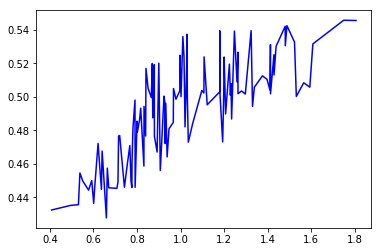

In [20]:
print("[baseline_time * 0.02, baseline_time] =", [baseline_time * 0.02, baseline_time])
min_y = 1
max_y = 0
for it, boosting in enumerate(boosting_parameters.keys()):
    results = {}
    times = []
    accuracies = []
    for res in boosting_res[boosting]:
        results[res['time']] = res['accuracy']
    for time in sorted(results.keys()):
        times.append(time)
        accuracies.append(results[time])
    min_y = min(np.min(accuracies), min_y)
    max_y = max(np.max(accuracies), max_y)
    plt.plot(times, accuracies, plt_colours[it], label=boosting)
plt.xlim([baseline_time * 0.02, baseline_time])
plt.ylim([min_y - 0.01, max_y + 0.01])
plt.xlabel('Time spent on test data, sec')
plt.ylabel('Score')
plt.title('Score/Time graph for all models')
plt.legend()
plt.show()